In [16]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time
from rasterstats import zonal_stats
from scipy.stats import pearsonr
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

def Trend_Score(df, index:int): 
    """Determines the trend score of a polygon it takes as input a dataframe that counts the fires per region per month and the index of a specific region and returns 
    the deviance score of that particular region"""
    if index in NOx_df.columns:
        df_selected = df[['ModifiedDateTime', index]]
        df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
        df_selected.index = df_selected['ModifiedDateTime']
    else:
        df_selected = pd.DataFrame()

    if not df_selected.empty:

        X = df_selected[index]

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(X,period=2, seasonal=7)
        res = stl.fit()

        df_trend = res.trend.to_frame().reset_index().dropna()

        #Date needs to be converted to a numerical value
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        #Set the data in the right format for Linear Regression
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)

        #Perform Linear Regression and obtain the slope
        reg = LinearRegression().fit(X, y)
        y_pred_trend = reg.predict(X)
        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        line_slope = slope[0]

    else:
        #If the dataframe is empty there are no fires in that region at all, also no slope line. We are not interested in these regions.
        line_slope = 'Unknown'

    return(line_slope)

def correlation(directory, beginyear, endyear, boundaries, level):
    
    
    #We will loop over all boundaries and calculate it's deviant score
    ids= []
    scores = []
    
    data = DFcreation(boundaries, directory )
    
    for i in range(0, len(boundaries['index'])):
        ids.append(boundaries['index'].iloc[i])
        #We use the previously defined function in order to calculate the trend score per specific area
        score = Trend_Score(data, i)
        scores.append(score)

    #Create a Dataframe from the scores
    DPPD_df = pd.DataFrame({'index': ids, 'Slope Score': scores}) 


    #Only select the regions that do not have unknown scores
    DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']

    #We merge the dataframe with the boundaries dataframe such that we have the geometry variable
    DPPD_df = DPPD_df.merge(boundaries[['index', 'geometry']], how='left', on=['index'])

    #Making sure data has the right type
    DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
    DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

    DPPD_df.to_csv('DPPD_Fires_'+str(beginyear) +'-' + str(endyear)+ level + '.csv')
    DPPD_df = gpd.GeoDataFrame(DPPD_df) 
    DPPD_df.to_file('DPPD_Fires_'+str(beginyear) +'-' + str(endyear)+level+'.geojson', driver="GeoJSON") 
    #Define text for the plots
    text = 'Changes in Amount of ' + level + ' level ('+ str(beginyear) +'-'+str(endyear)+')'

    vmin, vmax = DPPD_df['Slope Score'].min() , DPPD_df['Slope Score'].max()
    vcenter = DPPD_df['Slope Score'].mean()
    norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
    # create a normalized colorbar
    cmap = 'RdYlGn_r'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    base = boundaries.plot(color='white', edgecolor='black',figsize = [20,20])
    DPPD_df.plot(ax = base,
        column = 'Slope Score', 
                        legend = True, 
                        figsize = [20,20],\
                        legend_kwds = {'label': 'Deviance'}, 
                        cmap = 'RdYlGn_r',
                        norm = norm)
    plt.title(text)
    plt.savefig(text + '.png', bbox_inches='tight')

    return(plt.show(), DPPD_df)

def DFcreation(boundary, directory ):
    boundary = boundary.reset_index()
    columns =['index', 'geometry']
    NOx_df = boundaries[columns]
    tiffs = os.listdir(directory) #'NDVI/Karnataka/'
    x = '.ipynb_checkpoints'
    if x in tiffs:
        tiffs.remove(x)

    for tiff in tiffs:
        lulc = rasterio.open('NDVI/Karnataka/'+tiff, mode = 'r')
        lulc_array = lulc.read(1) 
        affine = lulc.transform
        
    ## VERY IMPORTANT!! Extract dates from the tif file names
    
        NOx_df[tiff[:10].replace("_", "-")] = 0
        for a in range(0, len(boundaries)):
            NOx_mean = zonal_stats(boundaries.iloc[a].geometry, lulc_array, affine = affine, geojson_out = True, nodata = lulc.nodata)[0]['properties']['mean']
            NOx_df[tiff[:10].replace("_", "-")].iloc[a] = NOx_mean


    NOx_df = NOx_df.dropna()
    NOx_df = NOx_df.iloc[:, 2:].transpose().reset_index()
    NOx_df['ModifiedDateTime'] = pd.to_datetime(NOx_df['index'])
    return Nox_df

In [1]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time
from rasterstats import zonal_stats
from scipy.stats import pearsonr
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
import raster_func  #import function python filee

boundary = gpd.read_file('Karnataka/District.geojson')

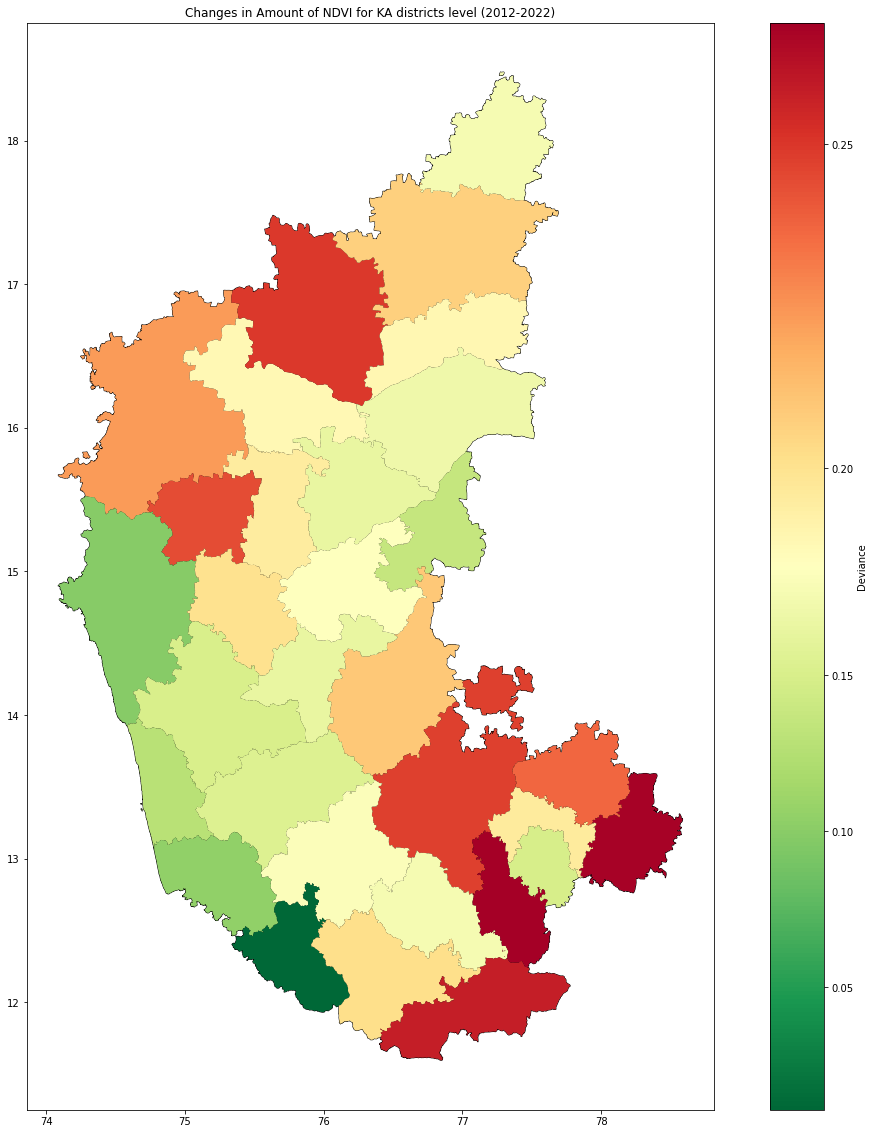

In [2]:
fig, df = raster_func.correlation('NDVI/Karnataka/', 2012, 2022,  boundary, 'NDVI for KA districts')